In [24]:
#import stuff
import pandas as pd
import numpy as np
import seaborn as s
from matplotlib import pyplot as plt
import lib as l
import copy
import tqdm

In [26]:
#import data
pokemon = pd.read_csv('data/pokemon.csv', header = None, 
                     skiprows=1, encoding = 'latin-1', low_memory = False,
                    names = ['Name', 'Version', 'Primary Type' ,'Secondary Type', 'Stage' ,'Attack', 'Defense' , 'HP', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Total', 'Legendary']
)
noMega = pokemon[pokemon['Version'].isnull()] # for KNN alg

img = plt.imread("logo.png") # get the pokemon logo :)

# Question 1;

This is the data set of all current pokemon as of 11/23/21. This represents a statistical outlook of the 1045 pokemon. This includes legendaries, mythical, and mega evolution variants. Their attributes are broken down into 7 numerical categories. They represents how strong the corresponding attribute of the pokemon is. So the higher the value, the stronger the attribute will be. The categories are as follows:

    - HP
    - Attack
    - Defense
    - Special Attack
    - Special Defense
    - Speed
    - Total
    
These are not the actual values of the attributes. _i.e._ If I have a Lvl 100 Venusaur, I won't have 82 Attack. It is more like a scale that determines the boundaries that a pokemon's attributes are tied to. 

# Question 2;

There are few, not so obvious **classes** that are present in this data set. One of which can be determining if a pokemon is considered _Statistically Strong_. This has a vague definition, but generally the higher the pokemon's attributes are, the better they can do in battle. For our purpose, we will define statistically strong as _having a higher total than 500, as well as having at least 3 of their 6 attributes being in the third quartile of all values._ This will hopefully eliminate any outliers or pokemon that have all their power in a few stats. **(Blissey)**

Another class is whether the pokemon have a secondary type or not. There really is no correlation with the data we currently have, but if we added a column that gave us the evolution stage that a pokemon is in, (1, 2, or 3), we could define secondary types with evolution stage as a potential class. 

## Important Statistics & Info of the Set:

1. We will be excluding ALL mega evolution forms of pokemon as well as **Eternamax** for our KNN alg because they will cause some annoying skewing.

2. For our K-means clustering algorithm, we will be including all 1045 pokemon. This will prove our point later on that K-means is NOT a good algorithm to use on this data set.

We will provide some basic stats about our set below:

In [15]:
stats = noMega.describe().round(3)
stats

,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,870.000,870.000,870.000,870.000,870.000,870.000,870.000,870.000
mean,1.614,76.017,71.511,68.706,69.117,69.387,65.143,419.882
std,0.704,29.471,29.533,26.272,29.061,26.859,28.110,110.641
min,1.000,5.000,5.000,1.000,10.000,20.000,5.000,180.000
25%,1.000,55.000,50.000,50.000,45.000,50.000,45.000,320.000
50%,1.000,75.000,67.000,65.000,65.000,65.000,64.000,430.000
75%,2.000,95.000,90.000,80.000,90.000,85.000,85.000,500.000
max,3.000,181.000,230.000,255.000,173.000,230.000,200.000,720.000


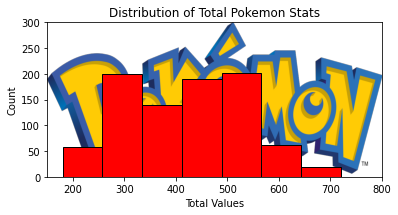

In [16]:
#distribution of total values (no mega or eternamax)
noMega['Total'].hist(color = 'red', ec = 'black', grid = False, bins = 7)
plt.title("Distribution of Total Pokemon Stats")
plt.xlabel("Total Values")
plt.ylabel("Count")
plt.imshow(img, extent = [150, 800, 0, 300])

# K-nearest Neighbors Algorithm

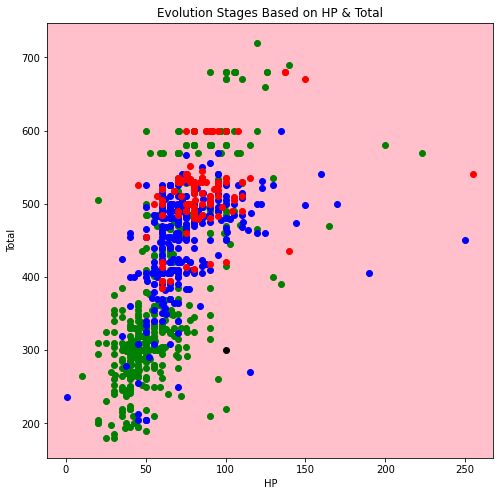

In [41]:
# SPLIT INTO OUR THREE STAGES 
stage_one = noMega[noMega['Stage'] == 1]
stage_two = noMega[noMega['Stage'] == 2]
stage_three = noMega[noMega['Stage'] == 3]

#PLOTTING
plt.scatter(x = stage_one['HP'], y = stage_one['Total'], color = 'g')
plt.scatter(x = stage_two['HP'], y = stage_two['Total'], color = 'b')
plt.scatter(x = stage_three['HP'], y = stage_three['Total'], color = 'r')
plt.scatter(x = random_pokemon[0], y = random_pokemon[1], color = 'black')
plt.title("Evolution Stages Based on HP & Total")
plt.xlabel("HP")
plt.ylabel("Total")
plt.gca().set_facecolor('pink')
plt.gcf().set_size_inches(8,8)

In [55]:
#Predicting what stage a pokemon is based off of HP and Total
knn = l.KNN(3)

knn_set = noMega[['HP', 'Total']].to_numpy()
labels = noMega['Stage'].values 

knn.train(knn_set, labels)

#test one
random_pokemon = [255,480]
pred = knn.predict(random_pokemon)

print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')

#test two
random_pokemon = [150,600]
pred = knn.predict(random_pokemon)

print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')

#test three
random_pokemon = [50,300]
pred = knn.predict(random_pokemon)

print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')
print("=======================================================")

The predicted stage of [255, 480] is ~> Stage 2
The predicted stage of [150, 600] is ~> Stage 1
The predicted stage of [50, 300] is ~> Stage 1


## Issues with this Algorithm
The problem lies with the **legendary** pokemon.

Majority of them don't have an evolution path, so they are all considered stage 1. Therefore, it severely skews the data. Thus being difficult to predict pokemon with higher stats.

Below we can see the means for each stage.

In [29]:
new = noMega[['Total' , 'Stage']]

one = new[new['Stage'] == 1]
two = new[new['Stage'] == 2]
three = new[new['Stage'] == 3]

print(one['Total'].mean())
print(two['Total'].mean())
print(three['Total'].mean())

377.36160714285717
446.9516129032258
515.0357142857143


Note that **Stage 1** has a fairly high total mean considering they are the *weak* pokemon. The legendaries very much skew the set to have a larger mean than intended. $ \\ $

In [30]:
def divideSets(p,data):
    copydata = copy.deepcopy(data)
    np.random.shuffle(copydata)
    list1 = copydata[:int(p*len(copydata))]
    list2 = copydata[int(p*len(copydata)):]
    return (list1,list2)


stages = noMega[['Total', 'Stage']].to_numpy()

p = 0.6
n = len(noMega['Total'])
rets = divideSets(p, stages)
list1 = rets[0]
list2 = rets[1]

data1 = [t[0] for t in list1]
print('\n Total Stats (data1): \n', data1)
label1 = [t[1] for t in list1]
print('\n Evolution Stage (Label1):\n', label1)

data2 = [t[0] for t in list2]
print('\n Total Stats (data2): \n', data2)
label2 = [t[1] for t in list2]
print('\n Evolution Stage (Label2):\n', label2)



 Total Stats (data1): 
 [490, 490, 330, 278, 275, 242, 200, 260, 273, 314, 335, 580, 405, 270, 535, 309, 290, 290, 240, 475, 303, 295, 540, 510, 500, 473, 680, 310, 330, 525, 395, 428, 497, 500, 525, 535, 329, 280, 510, 250, 320, 465, 410, 420, 315, 555, 270, 515, 410, 200, 490, 680, 245, 418, 500, 280, 300, 245, 580, 405, 335, 500, 290, 385, 330, 309, 505, 482, 245, 474, 500, 485, 200, 330, 580, 550, 210, 520, 480, 528, 475, 390, 483, 490, 380, 490, 370, 455, 495, 288, 316, 292, 355, 494, 340, 517, 520, 405, 430, 340, 600, 499, 455, 323, 294, 370, 280, 600, 400, 525, 375, 567, 325, 415, 500, 680, 483, 300, 455, 280, 300, 285, 490, 600, 530, 325, 680, 435, 475, 500, 309, 528, 490, 580, 510, 310, 355, 350, 498, 468, 320, 405, 545, 315, 310, 310, 570, 500, 440, 308, 360, 485, 500, 363, 270, 194, 530, 420, 265, 345, 395, 474, 460, 464, 340, 600, 405, 250, 330, 534, 435, 380, 525, 530, 390, 485, 420, 390, 500, 488, 355, 355, 495, 300, 540, 345, 310, 680, 505, 534, 475, 600, 410, 500, 325,

In [32]:
k = 3
knn = l.KNN(k)

knn.train(data1,label1)

prediction = []
for x in data2:
    prediction.append(knn.predict(x))
    
predictions = [(data2[i], prediction[i].most_common(2)) for i in range(len(prediction))]
print(predictions)


[(525, [(2, 2), (3, 1)]), (450, [(2, 3)]), (525, [(2, 2), (3, 1)]), (320, [(1, 3)]), (300, [(1, 3)]), (315, [(1, 3)]), (420, [(2, 2), (3, 1)]), (305, [(1, 3)]), (330, [(1, 3)]), (485, [(1, 2), (2, 1)]), (600, [(1, 3)]), (382, [(1, 3)]), (328, [(1, 3)]), (485, [(1, 2), (2, 1)]), (350, [(1, 3)]), (480, [(2, 2), (1, 1)]), (540, [(3, 2), (2, 1)]), (305, [(1, 3)]), (405, [(2, 2), (1, 1)]), (514, [(2, 2), (3, 1)]), (265, [(1, 3)]), (401, [(2, 3)]), (410, [(2, 3)]), (458, [(1, 2), (2, 1)]), (490, [(2, 1), (3, 1)]), (348, [(1, 2), (2, 1)]), (680, [(1, 3)]), (385, [(1, 1), (3, 1)]), (525, [(2, 2), (3, 1)]), (474, [(2, 3)]), (570, [(1, 3)]), (300, [(1, 3)]), (495, [(2, 2), (3, 1)]), (510, [(1, 1), (2, 1)]), (365, [(2, 2), (1, 1)]), (488, [(2, 3)]), (480, [(2, 2), (1, 1)]), (360, [(1, 2), (2, 1)]), (305, [(1, 3)]), (355, [(1, 2), (2, 1)]), (335, [(1, 3)]), (350, [(1, 3)]), (500, [(2, 3)]), (485, [(1, 2), (2, 1)]), (300, [(1, 3)]), (464, [(2, 2), (1, 1)]), (440, [(2, 2), (1, 1)]), (300, [(1, 3)]),

In [33]:
print('True Evolution Stages \n', label2)
print('\n Predicted Evolution Stages \n', predictions)
#print('\n Confusion Matrix: \n', confusion_matrix(label2,prediction))

True Evolution Stages 
 [3, 2, 2, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1, 2, 2, 1, 1, 2, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 1, 2, 1, 3, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 3, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 3, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 2, 3, 3, 1, 2, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 3, 1, 1, 1, 2, 2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 3, 1, 1, 3, 1, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 2, 1, 1, 2, 1, 2, 2, 1, 2, 3, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1, 3, 3, 2, 1, 1, 3, 2, 

# K-means Clustering

In [34]:
kMeans_set = pokemon[['Attack', 'Defense']].values
kMeans_set


array([[ 49,  49],
       [ 62,  63],
       [ 82,  83],
       ...,
       [ 80,  80],
       [165, 150],
       [ 85,  80]])

In [36]:
k = 3 
clusters = {}

for i in range(k):
    clusters[i] = []
#print(clusters)

centroids = {}
for i in range(k):
    centroids[i] = kMeans_set[i]
#print(centroids)

# ECUCLIDEAN DISTANCE
for i in kMeans_set:
    euc = []
    for j in range(k):
        euc.append(np.linalg.norm(i - centroids[j]))
    clusters[euc.index(min(euc))].append(i)
    
def recalculate_clusters(kMeans_set, centroids, k):
    # Initiate empty clusters
    clusters = {}
    # Set the range for value of k (number of centroids)
    for i in range(k):
        clusters[i] = []
    for data in kMeans_set:
        euc_dist = []
        for j in range(k):
            euc_dist.append(np.linalg.norm(data - centroids[j]))
        # Append the cluster of data to the dictionary
        clusters[euc_dist.index(min(euc_dist))].append(data)
    return clusters

def recalculate_centroids(centroids, clusters, k):

    for i in range(k):
        centroids[i] = np.average(clusters[i], axis=0)
    return centroids

#cent1 = centroids[0]
#cent2 = centroids[1]
#cent3 = centroids[2]